In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DATA_PATH = "/content/drive/MyDrive/the_datas/data/"
DATA_PATH

'/content/drive/MyDrive/the_datas/data/'

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import matplotlib
from matplotlib import font_manager

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

fontpaths = ["/usr/share/fonts/truetype/nanum/"]
font_files = font_manager.findSystemFonts(fontpaths=fontpaths)

for ff in font_files:
    font_manager.fontManager.addfont(ff)

matplotlib.rc('font', family="NanumGothic")
matplotlib.rcParams['axes.unicode_minus'] = False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (27.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123629 files and direc

In [5]:
import pandas as pd
import numpy as np

train_tr = pd.read_csv(f"{DATA_PATH}store_train_transactions.csv") # 학습용 구매기록 데이터
train_target = pd.read_csv(f"{DATA_PATH}store_train.csv") # 학습용 정답 데이터
test_tr = pd.read_csv(f"{DATA_PATH}store_test_transactions.csv") # 테스트용 구매기록 데이터
submit = pd.read_csv(f"{DATA_PATH}store_submission.csv") # 제출 양식 데이터

train_tr.shape , train_target.shape , test_tr.shape , submit.shape

((523105, 7), (14940, 2), (441196, 7), (12225, 2))

## train_tr 특성생성

In [6]:
train_tr["구매일시"] = pd.to_datetime(train_tr["구매일시"])
test_tr["구매일시"] = pd.to_datetime(test_tr["구매일시"])

In [7]:
train_tr['구매일'] = train_tr['구매일시'].dt.date
test_tr['구매일'] = test_tr['구매일시'].dt.date
train_tr.shape, test_tr.shape

((523105, 8), (441196, 8))

In [8]:
train_tr['구매월'] = train_tr['구매일시'].dt.month
test_tr['구매월'] = test_tr['구매일시'].dt.month
train_tr.shape, test_tr.shape

((523105, 9), (441196, 9))

In [9]:
train_tr['구매요일'] = train_tr['구매일시'].dt.weekday
test_tr['구매요일'] = test_tr['구매일시'].dt.weekday
train_tr.shape, test_tr.shape

((523105, 10), (441196, 10))

In [10]:
train_tr['구매시간'] = train_tr['구매일시'].dt.hour
test_tr['구매시간'] = test_tr['구매일시'].dt.hour
train_tr.shape, test_tr.shape

((523105, 11), (441196, 11))

In [11]:
train_tr['구매시간'].unique()

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,  1, 21, 22],
      dtype=int32)

In [12]:
train_tr[train_tr['구매시간'] == 1]

,ID,구매일시,지점코드,대분류,중분류,브랜드코드,구매가격,구매일,구매월,구매요일,구매시간
5801,train_6708,2004-05-05 01:18:00,A144000,케주얼_구두_아동,캐쥬얼구두,5469,-158000,2004-05-05,5,2,1


In [13]:
test_tr['구매시간'].unique()

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  9, 20,  1, 21,  0, 23,  8,
       22], dtype=int32)

In [14]:
test_tr[test_tr['구매시간'] == 1]

,ID,구매일시,지점코드,대분류,중분류,브랜드코드,구매가격,구매일,구매월,구매요일,구매시간
2357,test_2144,2004-05-03 01:15:00,A373000,가정용품,가전특정,5179,-3290000,2004-05-03,5,0,1
250298,test_5049,2004-11-20 01:30:00,A112000,공산품,용기보증,5100,49640,2004-11-20,11,5,1


In [15]:
train_tr.head()

,ID,구매일시,지점코드,대분류,중분류,브랜드코드,구매가격,구매일,구매월,구매요일,구매시간
0,train_13219,2004-05-01 09:40:00,A144000,공산품파트,차류,5100,59700,2004-05-01,5,5,9
1,train_5590,2004-05-01 09:40:00,A144000,잡화파트,화장잡화,5101,17000,2004-05-01,5,5,9
2,train_7200,2004-05-01 10:20:00,A112000,공산품,용기보증,5100,34937,2004-05-01,5,5,10
3,train_3010,2004-05-01 10:30:00,A373000,아동_스포츠,아동복,5105,19000,2004-05-01,5,5,10
4,train_10851,2004-05-01 10:30:00,A112000,가정용품,전화기_카세트,5110,215000,2004-05-01,5,5,10


## w/ target 결과

In [16]:
결과_비교 = pd.merge(train_tr, train_target, on="ID", how = "left")
train_tr_기혼 = 결과_비교[결과_비교['target'] == 0.0]
train_tr_미혼 = 결과_비교[결과_비교['target'] == 1.0]
train_tr_기혼.head(20)

,ID,구매일시,지점코드,대분류,중분류,브랜드코드,구매가격,구매일,구매월,구매요일,구매시간,target
0,train_13219,2004-05-01 09:40:00,A144000,공산품파트,차류,5100,59700,2004-05-01,5,5,9,0.0
1,train_5590,2004-05-01 09:40:00,A144000,잡화파트,화장잡화,5101,17000,2004-05-01,5,5,9,0.0
2,train_7200,2004-05-01 10:20:00,A112000,공산품,용기보증,5100,34937,2004-05-01,5,5,10,0.0
3,train_3010,2004-05-01 10:30:00,A373000,아동_스포츠,아동복,5105,19000,2004-05-01,5,5,10,0.0
4,train_10851,2004-05-01 10:30:00,A112000,가정용품,전화기_카세트,5110,215000,2004-05-01,5,5,10,0.0
6,train_12777,2004-05-01 10:30:00,A112000,공산품,일용잡화,5100,17000,2004-05-01,5,5,10,0.0
7,train_853,2004-05-01 10:30:00,A144000,잡화파트,수입종합화장품,5111,78000,2004-05-01,5,5,10,0.0
8,train_3089,2004-05-01 10:30:00,A144000,잡화파트,수입종합화장품,5112,24000,2004-05-01,5,5,10,0.0
9,train_35,2004-05-01 10:40:00,A112000,공산품,용기보증,5100,28358,2004-05-01,5,5,10,0.0
10,train_7200,2004-05-01 10:40:00,A112000,아동문화,아동,5122,26000,2004-05-01,5,5,10,0.0


# 지점별

In [17]:
train_tr["지점코드"].unique()

array(['A144000', 'A112000', 'A373000', 'A202000'], dtype=object)

In [18]:
train_tr_A144000 = 결과_비교[결과_비교["지점코드"] == "A144000"]
train_tr_A112000 = 결과_비교[결과_비교["지점코드"] == "A112000"]
train_tr_A373000 = 결과_비교[결과_비교["지점코드"] == "A373000"]
train_tr_A202000 = 결과_비교[결과_비교["지점코드"] == "A202000"]

In [19]:
train_tr_A144000["중분류"].unique(), train_tr_A112000["중분류"].unique(), train_tr_A373000["중분류"].unique(), train_tr_A202000["중분류"].unique()

(array(['차류', '화장잡화', '수입종합화장품', '테이프', '진케주얼', '용기보증', '트래디셔널', '야채',
        '수입부띠끄', '골프웨어', '영트랜드', '곡물', '스타킹', '레이디숍A', '하이캐쥬얼', '유아복',
        '헤어ACC', '타운단품', '란제리', '청과', '냉장식품', '아동', '잡화', '캐쥬얼구두', '내의',
        '일반조리', '스카프', '상품군미지정', '디자이너숍', '썬그라스', '캐릭터캐주얼', '완구', '수입의류',
        '준보석', '욕실용품', '캐릭터캐쥬얼', '수입캐주얼', '즉석조리', '일용잡화', '국내화장품', '임대구두',
        '미시케쥬얼', '취사소형', '스포츠웨어', '넥타이', '모자', '피혁B행사', '수입구두', '팬시',
        '색조화장품', '영캐쥬얼', '디자이너니트', '건식품', '핸드백', '크리스탈', '건강식품', '양말',
        '우산_장갑', '페레  지원', '국내부띠끄', '초도자기', '음료', '라이센스', '스포츠슈즈', '드레스구두',
        '셔츠', '상품개발지원', '문구', '패션시계', '주방용품', '냉장고.세탁기', '내셔날', '과자류',
        '면류', '수영복', '가정잡화', '인텔리젼스', '수입향수', '수입피혁', '정육', '주류', '보석',
        '일반ACC', '수입ACC', '피혁A행사', '골프단품', '생선', '아동특선', '임대골프', '조미료',
        '가방', '손수건', '수입도자기', '전화기', '냉난방', '모피', '일반식품명품', '수예행사', '수입',
        '머플러', '침구', '로얄수입행사', '통병조림', '라디오.카세트', '캐릭터', '냉동식품', 'DC캐주얼',
        '용품', '기타식품', '마춤', 'GBR  지원', '인스탄트식품', '가스렌지',

In [20]:
all_four = ['가방', '가정잡화', '건강식품', '곡물', '기타식품', '냉난방', '냉동식품', '냉장식품', '라이센스',
       '란제리', '머플러', '면류', '모자', '보석', '상품군미지정', '색조화장품', '생선', '셔츠',
       '손수건', '수영복', '수입도자기', '수입종합화장품', '스카프', '스키', '스타킹', '스포츠웨어',
       '야채', '양말', '욕실용품', '용기보증', '음료', '일반조리', '일용잡화', '정육', '조미료',
       '주류', '주방용품', '준보석', '즉석조리', '차류', '청과', '캐릭터', '크리스탈', '통병조림',
       '특정', '핸드백']

In [21]:
np.array(set(train_tr_A144000["중분류"].unique()) - set(all_four)), np.array(set(train_tr_A112000["중분류"].unique()) - set(all_four)), np.array(set(train_tr_A373000["중분류"].unique()) - set(all_four  )), np.array(set(train_tr_A202000["중분류"].unique()) - set(all_four))

(array({'영트랜드', '상품개발지원', '미시케쥬얼', '하이캐쥬얼', '특선행사', '단품(트래디셔널)', '골프웨어', '전화기', '가스렌지', '테이프', '잡화', '피혁A행사', '내셔날', '일반ACC', '단품행사', '수예행사', '아동', '임대핸드백', '캐릭터캐주얼', '수입향수', 'GBR  지원', '내의', '마춤', '로얄수입행사', '완구', '썬그라스', '수입', '취사소형', '임대골프', 'DC캐주얼', '국내화장품', '골프단품', '디자이너', '냉장고.세탁기', '디자이너숍', '진케주얼', '패션시계', '정장', '페레  지원', '과자류', '모피', '수입구두', '라디오.카세트', '임대구두', '수입ACC', '행사', '국내부띠끄', '스포츠단품', '건식품', '용품', '타운단품', '영캐쥬얼', '카페트', '트래디셔널', 'TV.VTR', '디자이너니트', '피혁소품', '일반식품명품', '헤어ACC', '캐릭터캐쥬얼', '레이디숍A', '팬시', '피혁B행사', '인스탄트식품', '화장잡화', '넥타이', '초도자기', '수입캐주얼', '스포츠슈즈', '수입의류', '인텔리젼스', '수입부띠끄', '아동특선', '사무용품', '드레스구두', '우산_장갑', '유아복', '수입피혁', '문구', '침구', '캐쥬얼구두', '오디오'},
       dtype=object),
 array({'수예_인테리어소품', '싸롱화', '향수', '트레디셔널캐주얼', '단품_행사', '침대', '골프웨어', '우산장갑', '내셔날', '원목_주니어', '패션ACC', '아동', '시계', '스포츠캐주얼', '디자이너부띠끄', '소형취사가전', '종합_수입', 'L_B침구', '완구', '문화', '미씨캐릭터', '수입의류행사', '디자이너', '영캐주얼', '단품_행사1', '단품_행사2', '골프용품', '과자류', '모피.피혁', '수입ACC', '유니섹스캐주얼', 'NB핸드백', '직수입침구', '

In [22]:
train_tr_A144000.groupby("ID")["구매가격"].sum().mean(), train_tr_A112000.groupby("ID")["구매가격"].sum().mean(), train_tr_A373000.groupby("ID")["구매가격"].sum().mean(), train_tr_A202000.groupby("ID")["구매가격"].sum().mean()

(2465413.381970763, 1735119.9009782048, 1879999.2020062695, 2224458.25447263)

In [23]:
train_tr_A144000.groupby("ID")["구매가격"].sum().max(), train_tr_A112000.groupby("ID")["구매가격"].sum().max(), train_tr_A373000.groupby("ID")["구매가격"].sum().max(), train_tr_A202000.groupby("ID")["구매가격"].sum().max()

(65413108, 99190685, 55378702, 80638814)

In [24]:
train_tr_A144000.groupby("ID")["구매가격"].sum().min(), train_tr_A112000.groupby("ID")["구매가격"].sum().min(), train_tr_A373000.groupby("ID")["구매가격"].sum().min(), train_tr_A202000.groupby("ID")["구매가격"].sum().min()

(-11784011, -1453576, -2127600, -743673)

In [25]:
train_tr_A144000.groupby("ID")["target"].mean().mean(), train_tr_A112000.groupby("ID")["target"].mean().mean(), train_tr_A373000.groupby("ID")["target"].mean().mean(), train_tr_A202000.groupby("ID")["target"].mean().mean()

(0.3742555495397943,
 0.47520164750300325,
 0.39974921630094046,
 0.34579439252336447)

In [26]:
train_tr_A144000.groupby("ID")["target"].mean().shape, train_tr_A112000.groupby("ID")["target"].mean().shape, train_tr_A373000.groupby("ID")["target"].mean().shape, train_tr_A202000.groupby("ID")["target"].mean().shape

((7388,), (5827,), (7975,), (3745,))

In [27]:
train_tr_A144000.groupby("중분류")["구매가격"].mean().mean(), train_tr_A112000.groupby("중분류")["구매가격"].mean().mean(), train_tr_A373000.groupby("중분류")["구매가격"].mean().mean(), train_tr_A202000.groupby("중분류")["구매가격"].mean().mean()

(159561.19439845986,
 140138.92713634783,
 136937.09945191428,
 136568.81324883972)

In [28]:
train_tr_A144000.groupby("중분류")["구매가격"].mean().sum(), train_tr_A112000.groupby("중분류")["구매가격"].mean().sum(), train_tr_A373000.groupby("중분류")["구매가격"].mean().sum(), train_tr_A202000.groupby("중분류")["구매가격"].mean().sum()

(20423832.883002862,
 18498338.381997913,
 16295514.834777799,
 18573358.601842202)

In [29]:
train_tr_A144000.groupby("중분류")["구매가격"].mean().max(), train_tr_A112000.groupby("중분류")["구매가격"].mean().max(), train_tr_A373000.groupby("중분류")["구매가격"].mean().max(), train_tr_A202000.groupby("중분류")["구매가격"].mean().max()

(1457921.0526315789, 1167118.4210526317, 778347.8260869565, 953833.3928571428)

In [30]:
#지점별 대분류 구매비율
import pandas as pd

# 지점별로 각 대분류의 구매 횟수 집계
category_counts = train_tr.groupby(['지점코드', '대분류']).size().unstack(fill_value=0)

# 지점별 총 구매 횟수를 기준으로 각 대분류 비율 계산
category_ratios = category_counts.div(category_counts.sum(axis=1), axis=0)

# 결과 확인
category_ratios.head()


대분류,가정용품,가정용품파트,골프_유니캐쥬얼,공산품,공산품파트,남성의류,남성정장스포츠,로얄부띠끄,로얄부틱,명품잡화,...,여성캐주얼,여성캐쥬얼,영라이브,영어덜트캐쥬얼,영캐릭터,영플라자,잡화,잡화파트,케주얼_구두_아동,패션잡화
지점코드,,,,,,,,,,,,,,,,,,,,,
A112000,0.062567,0.000000,0.000000,0.130181,0.000000,0.041600,0.000000,0.000000,0.00000,0.00000,...,0.054607,0.000000,0.000000,0.00000,0.056004,0.156466,0.000000,0.000000,0.000000,0.211033
A144000,0.000000,0.059819,0.000000,0.000000,0.143737,0.000000,0.091271,0.036373,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.242533,0.242482,0.000000
A202000,0.075665,0.000000,0.000000,0.123053,0.000000,0.043929,0.000000,0.000000,0.02227,0.00000,...,0.000000,0.062028,0.101966,0.07006,0.000000,0.000000,0.181422,0.000000,0.000000,0.000000
A373000,0.060253,0.000000,0.115435,0.128206,0.000000,0.051240,0.000000,0.000000,0.00000,0.27267,...,0.096112,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025135


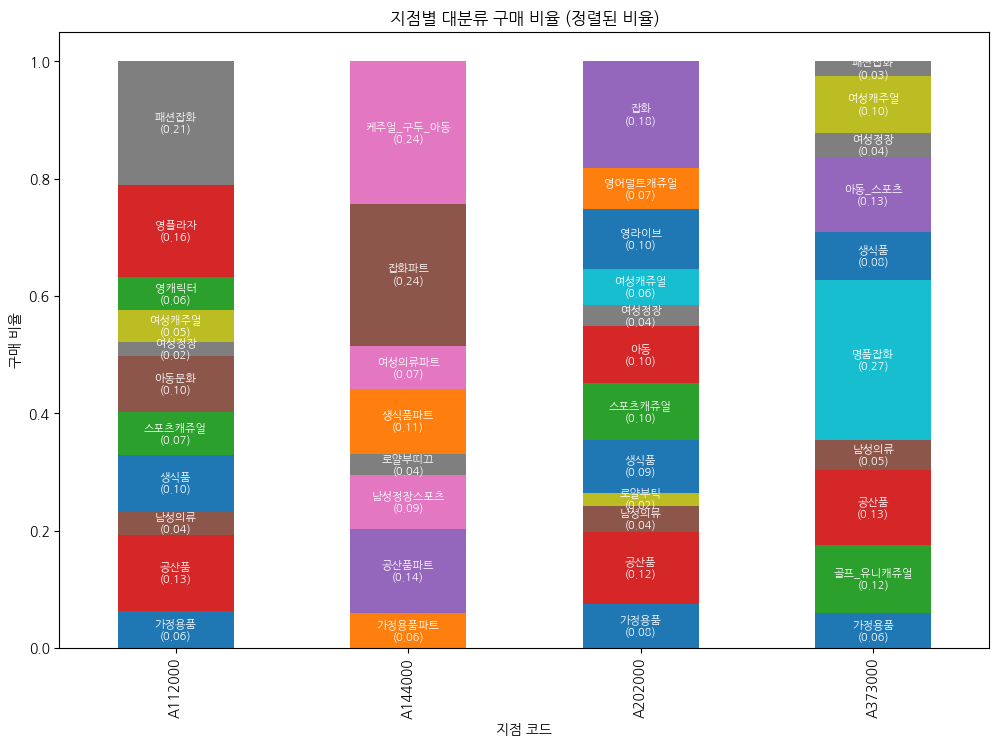

In [31]:
import matplotlib.pyplot as plt

# 각 지점별 대분류 구매 비율을 비율 기준으로 내림차순 정렬한 후 새로 생성
sorted_category_ratios = category_ratios.apply(lambda row: row.sort_values(ascending=False), axis=1)

# 막대그래프 시각화
fig, ax = plt.subplots(figsize=(12, 8))
bars = sorted_category_ratios.plot(kind='bar', stacked=True, ax=ax, legend=False)

# 각 막대의 중앙에 대분류 이름을 추가
for i, category in enumerate(sorted_category_ratios.columns):
    for bar in ax.containers[i]:
        if bar.get_height() > 0:  # 0이 아닌 막대에만 텍스트 표시
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f'{category}\n({bar.get_height():.2f})',  # 대분류 이름과 비율값 삽입
                ha='center',
                va='center',
                fontsize=8,
                color='white'
            )

plt.title("지점별 대분류 구매 비율 (정렬된 비율)")
plt.ylabel("구매 비율")
plt.xlabel("지점 코드")
plt.show()


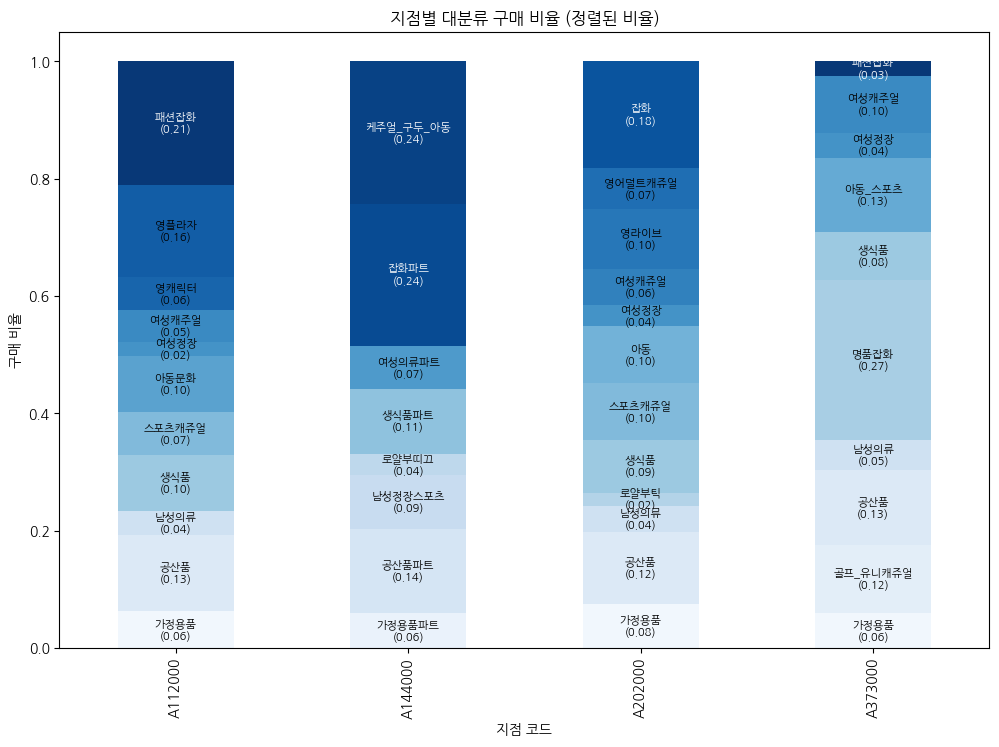

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# 색상 팔레트 생성
palette = sns.color_palette("Blues", len(sorted_category_ratios.columns))

# 막대그래프 시각화
fig, ax = plt.subplots(figsize=(12, 8))
bars = sorted_category_ratios.plot(kind='bar', stacked=True, ax=ax, color=palette, legend=False)

# 상위 4개 진한 색상에는 흰색 글씨, 나머지는 검은 글씨 적용
for i, category in enumerate(sorted_category_ratios.columns):
    for bar in ax.containers[i]:
        if bar.get_height() > 0:  # 0이 아닌 막대에만 텍스트 표시
            text_color = 'white' if i >= len(palette) - 4 else 'black'  # 상위 4개의 색은 흰색 글씨
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f'{category}\n({bar.get_height():.2f})',  # 대분류 이름과 비율값 삽입
                ha='center',
                va='center',
                fontsize=8,
                color=text_color
            )

plt.title("지점별 대분류 구매 비율 (정렬된 비율)")
plt.ylabel("구매 비율")
plt.xlabel("지점 코드")
plt.show()


In [33]:
# 각 지점의 대분류 목록을 집합(set)으로 변환
categories_A144000 = set(train_tr_A144000["대분류"].unique())
categories_A112000 = set(train_tr_A112000["대분류"].unique())
categories_A373000 = set(train_tr_A373000["대분류"].unique())
categories_A202000 = set(train_tr_A202000["대분류"].unique())

# 네 개 지점의 대분류 목록의 교집합 구하기
common_categories =   categories_A112000 & categories_A373000 & categories_A202000 #categories_A144000 &

# 결과 출력
print("모든 지점에 공통으로 포함된 대분류:", common_categories)


모든 지점에 공통으로 포함된 대분류: {'가정용품', '생식품', '여성정장', '남성의류', '공산품'}


In [33]:
#월별 거래횟수 집계 막대 그래프


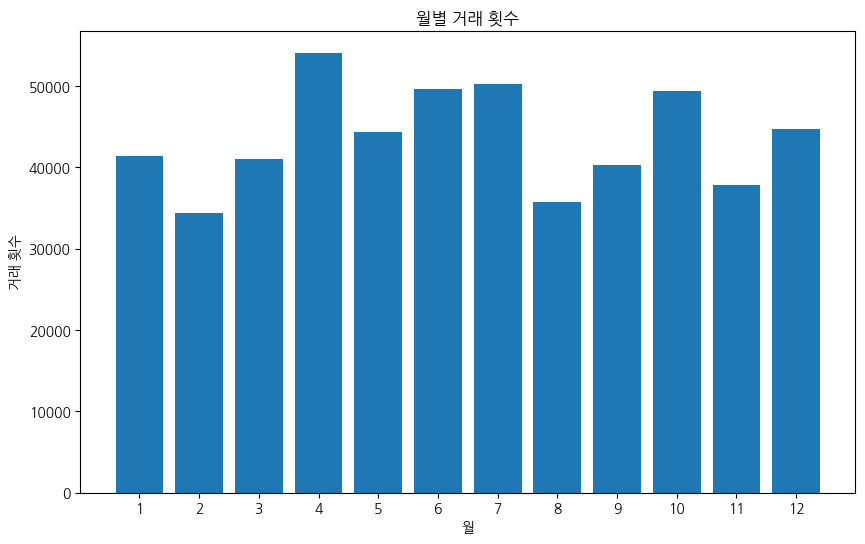

In [41]:
# prompt: 월별 거래횟수 집계 막대 그래프

# 월별 거래횟수 집계 및 막대 그래프 생성
monthly_transactions = train_tr.groupby('구매월').size()

plt.figure(figsize=(10, 6))
plt.bar(monthly_transactions.index, monthly_transactions.values)
plt.title('월별 거래 횟수')
plt.xlabel('월')
plt.ylabel('거래 횟수')
plt.xticks(monthly_transactions.index)  # x축 눈금 설정
plt.show()

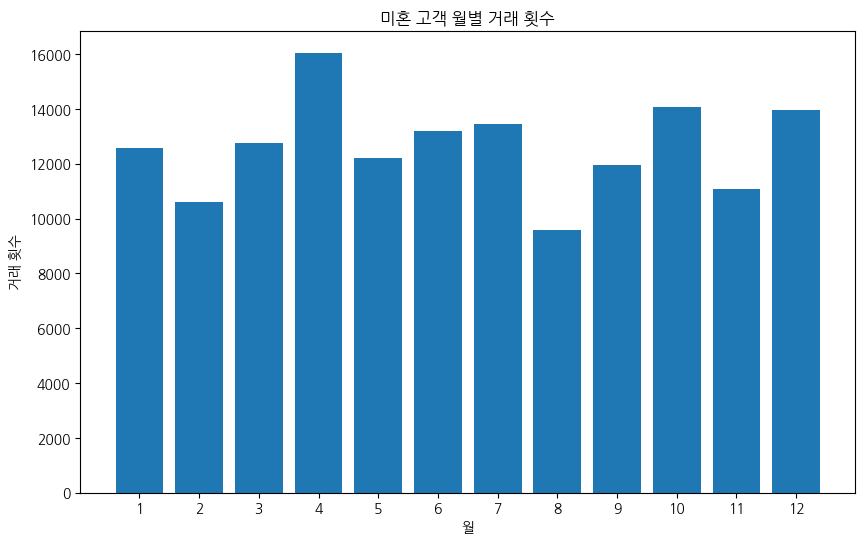

In [42]:
# prompt: 미혼일때 월별 거래횟수 막대 그래프

# 미혼 고객의 월별 거래 횟수 집계 및 막대 그래프 생성
monthly_transactions_single = train_tr_미혼.groupby('구매월').size()

plt.figure(figsize=(10, 6))
plt.bar(monthly_transactions_single.index, monthly_transactions_single.values)
plt.title('미혼 고객 월별 거래 횟수')
plt.xlabel('월')
plt.ylabel('거래 횟수')
plt.xticks(monthly_transactions_single.index)  # x축 눈금 설정
plt.show()

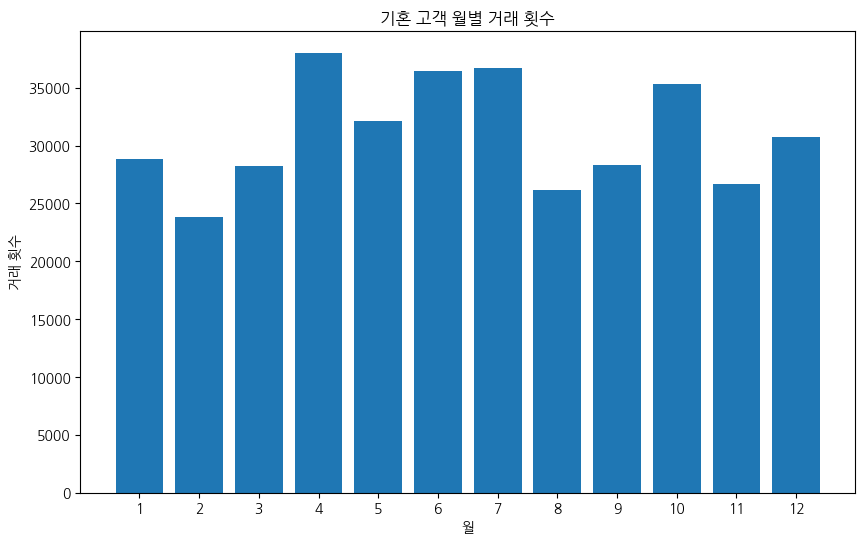

In [43]:
monthly_transactions_single = train_tr_기혼.groupby('구매월').size()

plt.figure(figsize=(10, 6))
plt.bar(monthly_transactions_single.index, monthly_transactions_single.values)
plt.title('기혼 고객 월별 거래 횟수')
plt.xlabel('월')
plt.ylabel('거래 횟수')
plt.xticks(monthly_transactions_single.index)  # x축 눈금 설정
plt.show()